In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# 1️⃣ Import all required libraries
import os
import cv2
import torch
import torch.nn as nn
import timm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
!unzip "/content/drive/MyDrive/processed_faces.zip" -d "/content/data"


Streaming output truncated to the last 5000 lines.
  inflating: /content/data/content/processed_faces/real/35249.jpg  
  inflating: /content/data/content/processed_faces/real/50116.jpg  
  inflating: /content/data/content/processed_faces/real/55046.jpg  
  inflating: /content/data/content/processed_faces/real/62951.jpg  
  inflating: /content/data/content/processed_faces/real/09486.jpg  
  inflating: /content/data/content/processed_faces/real/11732.jpg  
  inflating: /content/data/content/processed_faces/real/25664.jpg  
  inflating: /content/data/content/processed_faces/real/14668.jpg  
  inflating: /content/data/content/processed_faces/real/49412.jpg  
  inflating: /content/data/content/processed_faces/real/40549.jpg  
  inflating: /content/data/content/processed_faces/real/30748.jpg  
  inflating: /content/data/content/processed_faces/real/04869.jpg  
  inflating: /content/data/content/processed_faces/real/37659.jpg  
  inflating: /content/data/content/processed_faces/real/23496.jpg

In [5]:
# 1️⃣ Load Data
train_df = pd.read_csv("/content/data/content/processed_faces/forgery_train.csv")
val_df = pd.read_csv("/content/data/content/processed_faces/forgery_val.csv")

In [6]:
train_df = train_df.drop(columns=['path'])
val_df = val_df.drop(columns=['path'])



In [7]:
print(train_df.columns)
print(val_df.columns)



Index(['image_path', 'label'], dtype='object')
Index(['image_path', 'label'], dtype='object')


In [8]:
# 2️⃣ Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [9]:
# 3️⃣ Define Dataset class
class ForgeryDataset(Dataset):
    def __init__(self, df, base_dir=None, transform=None):
        self.df = df.reset_index(drop=True)
        self.base_dir = base_dir
        self.transform = transform

        # Pre-filter valid images
        self.valid_indices = []
        print("Validating images...")
        for idx in tqdm(range(len(self.df)), desc="Checking images"):
            row = self.df.iloc[idx]
            if self.base_dir:
                img_path = os.path.join(self.base_dir, row["image_path"])
            else:
                img_path = row["image_path"]

            if os.path.exists(img_path):
                img = cv2.imread(img_path)
                if img is not None:
                    self.valid_indices.append(idx)

        print(f"Found {len(self.valid_indices)} valid images out of {len(self.df)}")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        row = self.df.iloc[actual_idx]

        if self.base_dir:
            img_path = os.path.join(self.base_dir, row["image_path"])
        else:
            img_path = row["image_path"]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        label = 1 if row["label"] == "fake" else 0

        return img, label

In [10]:
# 4️⃣ Evaluation function
def evaluate(model, loader, criterion, device, phase="Validation"):
    """Evaluate model on validation/test set"""
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=f"{phase}"):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy, all_preds, all_labels, all_probs

In [11]:
# 5️⃣ Print detailed metrics
def print_metrics(true_labels, predictions, probabilities, phase="Validation"):
    """Print detailed evaluation metrics"""
    print("\n" + "="*70)
    print(f"{phase.upper()} RESULTS")
    print("="*70)

    # Classification Report
    print("\nCLASSIFICATION REPORT:")
    print("-"*70)
    print(classification_report(true_labels, predictions,
                                target_names=['Real', 'Fake'],
                                digits=4))

    # Confusion Matrix
    print("\nCONFUSION MATRIX:")
    print("-"*70)
    cm = confusion_matrix(true_labels, predictions)
    print(f"                    Predicted Real    Predicted Fake")
    print(f"Actual Real         {cm[0,0]:<17} {cm[0,1]:<17}")
    print(f"Actual Fake         {cm[1,0]:<17} {cm[1,1]:<17}")

    print("\nDETAILED BREAKDOWN:")
    print("-"*70)
    print(f"True Negatives (Real->Real):  {cm[0,0]}")
    print(f"False Positives (Real->Fake): {cm[0,1]}")
    print(f"False Negatives (Fake->Real): {cm[1,0]}")
    print(f"True Positives (Fake->Fake):  {cm[1,1]}")

    # Additional Metrics
    print("\nADDITIONAL METRICS:")
    print("-"*70)
    try:
        roc_auc = roc_auc_score(true_labels, probabilities)
        print(f"ROC-AUC Score: {roc_auc:.4f}")
    except:
        print("ROC-AUC Score: Could not be calculated")

    # Calculate precision, recall, F1
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision (Fake): {precision:.4f}")
    print(f"Recall (Fake):    {recall:.4f}")
    print(f"F1-Score (Fake):  {f1:.4f}")
    print("="*70 + "\n")

In [12]:
# 6️⃣ Create datasets
base_dir = "/content/data/content/processed_faces"

In [13]:
print("Creating Training Dataset...")
train_dataset = ForgeryDataset(train_df, base_dir=base_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("\nCreating Validation Dataset...")
val_dataset = ForgeryDataset(val_df, base_dir=base_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Creating Training Dataset...
Validating images...


Checking images: 100%|██████████| 16000/16000 [00:01<00:00, 8034.04it/s]


Found 4881 valid images out of 16000

Creating Validation Dataset...
Validating images...


Checking images: 100%|██████████| 4000/4000 [00:00<00:00, 8012.93it/s]

Found 1241 valid images out of 4000


In [14]:
# 7️⃣ Model setup
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
criterion = nn.CrossEntropyLoss()
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the classifier head
for param in model.head.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(model.head.parameters(), lr=1e-3)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [17]:
# 8️⃣ Training loop with validation
num_epochs = 20
best_val_acc = 0.0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [18]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation phase
    val_loss, val_acc, val_preds, val_labels, val_probs = evaluate(
        model, val_loader, criterion, device, phase=f"Epoch {epoch+1}/{num_epochs} [Validation]"
    )

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Print epoch summary
    print(f"\n{'='*70}")
    print(f"EPOCH {epoch+1}/{num_epochs} SUMMARY")
    print(f"{'='*70}")
    print(f"Training   -> Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"Validation -> Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
    print(f"{'='*70}\n")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_path = "/content/best_forgery_model.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_acc,
            'val_loss': val_loss,
            'model_name': 'vit_base_patch16_224',
        }, best_model_path)
        print(f"✓ Best model saved! (Val Accuracy: {val_acc:.2f}%)\n")

print("\nTraining completed!")

Epoch 1/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.49it/s]



EPOCH 1/20 SUMMARY
Training   -> Loss: 0.5570, Accuracy: 71.05%
Validation -> Loss: 0.4759, Accuracy: 76.55%

✓ Best model saved! (Val Accuracy: 76.55%)



Epoch 2/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.49it/s]



EPOCH 2/20 SUMMARY
Training   -> Loss: 0.4190, Accuracy: 81.27%
Validation -> Loss: 0.4396, Accuracy: 78.32%

✓ Best model saved! (Val Accuracy: 78.32%)



Epoch 3/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.47it/s]



EPOCH 3/20 SUMMARY
Training   -> Loss: 0.3766, Accuracy: 83.53%
Validation -> Loss: 0.4238, Accuracy: 79.69%

✓ Best model saved! (Val Accuracy: 79.69%)



Epoch 4/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.48it/s]



EPOCH 4/20 SUMMARY
Training   -> Loss: 0.3502, Accuracy: 85.25%
Validation -> Loss: 0.3667, Accuracy: 83.88%

✓ Best model saved! (Val Accuracy: 83.88%)



Epoch 5/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.47it/s]



EPOCH 5/20 SUMMARY
Training   -> Loss: 0.3275, Accuracy: 86.27%
Validation -> Loss: 0.3736, Accuracy: 82.19%



Epoch 6/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.47it/s]



EPOCH 6/20 SUMMARY
Training   -> Loss: 0.3159, Accuracy: 86.99%
Validation -> Loss: 0.3736, Accuracy: 82.76%



Epoch 7/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.46it/s]



EPOCH 7/20 SUMMARY
Training   -> Loss: 0.3053, Accuracy: 87.48%
Validation -> Loss: 0.3512, Accuracy: 83.80%



Epoch 8/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.46it/s]



EPOCH 8/20 SUMMARY
Training   -> Loss: 0.2940, Accuracy: 88.20%
Validation -> Loss: 0.3436, Accuracy: 85.74%

✓ Best model saved! (Val Accuracy: 85.74%)



Epoch 9/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.49it/s]



EPOCH 9/20 SUMMARY
Training   -> Loss: 0.2888, Accuracy: 88.12%
Validation -> Loss: 0.3506, Accuracy: 83.48%



Epoch 10/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.48it/s]



EPOCH 10/20 SUMMARY
Training   -> Loss: 0.2780, Accuracy: 88.63%
Validation -> Loss: 0.3429, Accuracy: 84.77%



Epoch 11/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.48it/s]



EPOCH 11/20 SUMMARY
Training   -> Loss: 0.2747, Accuracy: 88.51%
Validation -> Loss: 0.3303, Accuracy: 84.85%



Epoch 12/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.49it/s]



EPOCH 12/20 SUMMARY
Training   -> Loss: 0.2701, Accuracy: 89.14%
Validation -> Loss: 0.3538, Accuracy: 83.96%



Epoch 13/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.48it/s]



EPOCH 13/20 SUMMARY
Training   -> Loss: 0.2615, Accuracy: 89.49%
Validation -> Loss: 0.3358, Accuracy: 85.25%



Epoch 14/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.48it/s]



EPOCH 14/20 SUMMARY
Training   -> Loss: 0.2567, Accuracy: 89.80%
Validation -> Loss: 0.3564, Accuracy: 84.13%



Epoch 15/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.47it/s]



EPOCH 15/20 SUMMARY
Training   -> Loss: 0.2610, Accuracy: 89.18%
Validation -> Loss: 0.3412, Accuracy: 84.69%



Epoch 16/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.47it/s]



EPOCH 16/20 SUMMARY
Training   -> Loss: 0.2542, Accuracy: 89.63%
Validation -> Loss: 0.3367, Accuracy: 86.22%

✓ Best model saved! (Val Accuracy: 86.22%)



Epoch 17/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.49it/s]



EPOCH 17/20 SUMMARY
Training   -> Loss: 0.2571, Accuracy: 89.63%
Validation -> Loss: 0.3396, Accuracy: 85.09%



Epoch 18/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.49it/s]



EPOCH 18/20 SUMMARY
Training   -> Loss: 0.2493, Accuracy: 89.98%
Validation -> Loss: 0.3343, Accuracy: 85.58%



Epoch 19/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.48it/s]



EPOCH 19/20 SUMMARY
Training   -> Loss: 0.2397, Accuracy: 90.45%
Validation -> Loss: 0.3252, Accuracy: 86.22%



Epoch 20/20 [Validation]: 100%|██████████| 39/39 [00:15<00:00,  2.48it/s]


EPOCH 20/20 SUMMARY
Training   -> Loss: 0.2417, Accuracy: 90.08%
Validation -> Loss: 0.3366, Accuracy: 85.41%


Training completed!


In [19]:
# 9️⃣ Final validation evaluation with detailed metrics
print("\n" + "="*70)
print("FINAL VALIDATION EVALUATION")
print("="*70)
val_loss, val_acc, val_preds, val_labels, val_probs = evaluate(
    model, val_loader, criterion, device, phase="Final Validation"
)
print_metrics(val_labels, val_preds, val_probs, phase="Validation")


FINAL VALIDATION EVALUATION


Final Validation: 100%|██████████| 39/39 [00:15<00:00,  2.48it/s]


VALIDATION RESULTS

CLASSIFICATION REPORT:
----------------------------------------------------------------------
              precision    recall  f1-score   support

        Real     0.8700    0.8636    0.8668       682
        Fake     0.8351    0.8426    0.8388       559

    accuracy                         0.8541      1241
   macro avg     0.8526    0.8531    0.8528      1241
weighted avg     0.8543    0.8541    0.8542      1241


CONFUSION MATRIX:
----------------------------------------------------------------------
                    Predicted Real    Predicted Fake
Actual Real         589               93               
Actual Fake         88                471              

DETAILED BREAKDOWN:
----------------------------------------------------------------------
True Negatives (Real->Real):  589
False Positives (Real->Fake): 93
False Negatives (Fake->Real): 88
True Positives (Fake->Fake):  471

ADDITIONAL METRICS:
--------------------------------------------------------

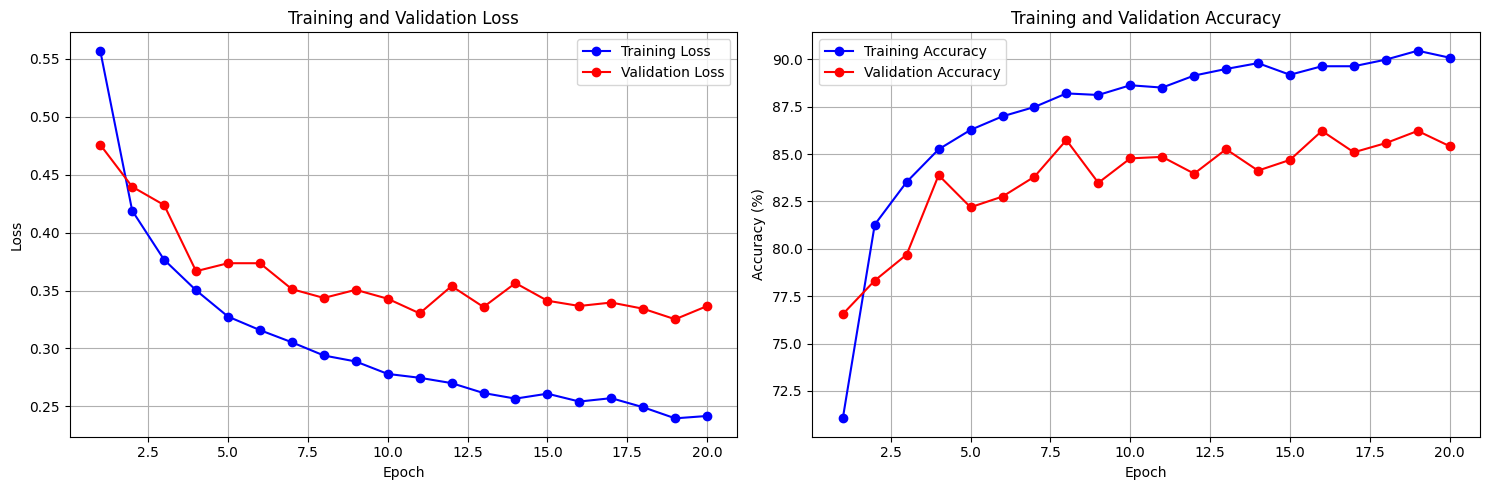


Training curves saved to: /content/training_curves.png
Best validation accuracy: 86.22%


In [20]:
# 🔟 Plot training curves
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, 'b-o', label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, 'r-o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, 'b-o', label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, 'r-o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTraining curves saved to: /content/training_curves.png")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

In [21]:
# 1️⃣1️⃣ Save final model
final_model_path = "/content/final_forgery_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'model_name': 'vit_base_patch16_224',
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
}, final_model_path)
print(f"Final model saved to: {final_model_path}")

Final model saved to: /content/final_forgery_model.pth


In [22]:
def predict_single_image(model, image_path, transform, device):
    """Predict if a single image is real or fake"""
    # Load and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        return None, None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        pred = torch.argmax(output, dim=1).item()
        confidence = probs[0, pred].item() * 100

    result = "FAKE" if pred == 1 else "REAL"
    return result, confidence

In [24]:
# Example usage
image_path = "/content/data/content/processed_faces/fake/00CB415UQ7.jpg"
result, confidence = predict_single_image(model, image_path, transform, device)
print(f"Prediction: {result} (Confidence: {confidence:.2f}%)")

Prediction: FAKE (Confidence: 80.41%)
